# <center>Network Science</center>

## <center/>Project #2
    Submitted By: Mohammed Bilal Ansari

#### Proposed Approach:

    Following steps has been used to implement the proposed model.

    Steps:
    1) Data Preparation 
       In this step, we first split the data into train and test interval. Futher, we compute negative examples using the train interval graph. 80/10 ratio has been considered for train_set and test_set with equal number of positive and negative examples.
    
    2) Feature Engineering
       We computer the features like jaccard, cosine, common_neighbors, resource_allocation etc. for each examples in train set and test set
    
    3) Model Training
       We considered the CatBoost algorithm to perform this task(i.e. link/contacts prediction) as binary classification problem.
       
    4) Model Performance
       Model has been evaluated using ROC_AUC score. 

#### Import required packages

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
import math
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import community
plt.xkcd()

## 1. Data Preparation

> #### Split the data into train and test interval

In [4]:
def split(data):
    """split the data into train and test interval"""
    # delete negative time data
    data = data[~(data['time'] < 0)]
    # consider the nodes with degree >= 5
    hist = pd.concat([data.userID_1, data.userID_2]).value_counts()
    sign_nodes = hist[ hist > 4 ].keys()
    data = data[(data['userID_1'].isin(sign_nodes) & data['userID_2'].isin(sign_nodes))]
    # 
    train_int = data[(data['time'] <= np.median(data['time'])) ].drop_duplicates()
    test_int = data[(data['time'] > np.median(data['time'])) ].drop_duplicates()
    # Drop time attribute
    train_int = train_int.drop(['time'], axis=1).reset_index(drop=True)
    test_int = test_int.drop(['time'], axis=1).reset_index(drop=True)
    return train_int, test_int 

In [5]:
flickr = pd.read_csv('contacts.txt', 
                     header=None, 
                     sep=' ', 
                     names = ['userID_1', 'userID_2', 'time'])

In [6]:
train_int, test_int = split(flickr)

> #### Create a graph of training interval

In [7]:
G_train = nx.from_pandas_edgelist(train_int, 
                                  'userID_1', 'userID_2',
                                  create_using = nx.Graph())

In [8]:
cc = nx.number_connected_components(G_train)
print(nx.info(G_train),'\n', 
      'Number of Connected Componets: ', cc, sep='')

Name: 
Type: Graph
Number of nodes: 106664
Number of edges: 1198072
Average degree:  22.4644
Number of Connected Componets: 2466


> #### Generate Negative Examples
    Negative examples are such pairs of users that have not occured    together during training and testing intervals

In [9]:
lookup = dict()
for index, user in train_int.append(test_int).iterrows():
    lookup[(user[0], user[1])] = 1
    lookup[(user[1], user[1])] = 1

In [10]:
neg_example = set([])
nodes = list(G_train.nodes)
pbar = tqdm(total = 1198072, desc='Finding Negative Examples')

while (len(neg_example)<1198072):
    user_1 = random.choice(nodes)
    user_2 = random.choice(nodes) 
    found = lookup.get((user_1,user_2),0) 
    try:
        sp = nx.shortest_path_length(G_train,source=user_1,target=user_2)
    except:
        sp = 1198072
    if found == 0 and user_1!=user_2 and sp>2:
        if (user_1,user_2) not in neg_example and (user_2,user_1) not in neg_example:
            neg_example.add((user_1,user_2))
    pbar.update(1)

In [11]:
df_neg = pd.DataFrame(list(neg_example), 
                      columns=['userID_1', 'userID_2'])

In [12]:
df_neg['is_Connected'] = 0

In [13]:
train_neg, test_neg  = train_test_split(df_neg, test_size=0.2)

> #### Positive Examples
    Positive examples are such pairs of users that haven't been formed during training interval but have been formed by testing interval.

In [14]:
# Authors in train_set and test set 
unique_train = pd.concat([train_int['userID_1'], train_int['userID_2']]).unique()
unique_test = pd.concat([test_int['userID_1'], test_int['userID_2']]).unique()
# Common authors in train_set and test_set
inter = np.intersect1d(unique_train, unique_test)
#
test_int = test_int[(test_int['userID_1'].isin(inter) & test_int['userID_2'].isin(inter))]

In [15]:
train_int['is_Connected'] = 1
test_int['is_Connected'] = 1

> #### Split the data into Train and Test set 

In [16]:
train_set = train_int.sample(n=train_neg.shape[0]).append(
    train_neg,ignore_index=True)

In [17]:
test_set = test_int.sample(n=test_neg.shape[0]).append(
    test_neg,ignore_index=True)

In [24]:
print('='*20,'TRAIN_SET','='*20)
print("Number of positive examples", 
      train_set[train_set.is_Connected==1].shape[0])
print("Number of negative examples", 
      train_set[train_set.is_Connected==0].shape[0])
print('='*20,'TEST_SET','='*21)
print("Number of positive examples", 
      test_set[test_set.is_Connected==1].shape[0])
print("Number of negative examples", 
      test_set[test_set.is_Connected==0].shape[0])

==================== TRAIN_SET ====================
Number of positive examples 958457
Number of negative examples 958457
==================== TEST_SET =====================
Number of positive examples 239615
Number of negative examples 239615


## 2. Feature Engineering

>    We will follow the below references to generate the new features
>    for our link prediction model.
>
>    References:
>
>    [Paper on Project recommendation system](https://arxiv.org/pdf/1602.02594.pdf)
>    
>    [Networkx Documentation](https://networkx.github.io/documentation/networkx-1.10/reference/algorithms.link_prediction.html)
   
   

In [25]:
def generate_features(G, df):
    jaccard = []
    cosine_dst = []
    num_con_s = []
    num_con_d = []
    common_neighbors = []
    adar = []
    page_rank_s = []
    page_rank_d = []
    hub_score_s = []
    hub_score_d = []
    auth_score_s = []
    auth_score_d = []
    preferential_att = []
    resource_alloc = []
    within_inter_c = []
    resource_alloc_c = []
    common_neighbors_c = []
    
    for r in tqdm(df.iterrows(), total=df.shape[0]):
        nb_v = set(G.neighbors(r[1]['userID_1']))
        nb_w = set(G.neighbors(r[1]['userID_2']))
        union = nb_v | nb_w
        inter = nb_v & nb_w
        ## Jaccard’s coefficient
        jaccard.append(len(inter) / len(union))
        ## Cosine Distance
        cosine_dst.append(len(inter)/ math.sqrt(len(union)))
        ## Number of connection user_1 has
        num_con_s.append(len(nb_v))
        ## Number of connection user_2 has
        num_con_d.append(len(nb_w))
        ## Number of common neighbors
        common_neighbors.append(len(inter))
        ## Adamic/Adar
        a = 0
        for node in inter:
            a += 1.0 / np.log(G.degree(node))
        adar.append(a)
        ## Page Rank for user_1
        page_rank_s.append(pr.get(r[1]['userID_1'], mean_pr))
        ## Page Rank for user_2
        page_rank_d.append(pr.get(r[1]['userID_2'], mean_pr))
        ## Hub score for user_1
        hub_score_s.append(hits[0].get(r[1]['userID_1'],0))
        ## Hub score for user_2
        hub_score_d.append(hits[0].get(r[1]['userID_2'],0))
        ## Authorities score for user_1
        auth_score_s.append(hits[1].get(r[1]['userID_1'],0))
        ## Authorities score for user_2
        auth_score_d.append(hits[1].get(r[1]['userID_2'],0))
        ## Preferential attachment
        preferential_att.append(len(nb_v) * len(nb_w))
        ## Resource allocation
        ra = 0
        for node in inter:
            ra += 1.0 / G.degree(node)
        resource_alloc.append(ra)
        ## ratio of within- and inter-cluster common neighbors 
        try:
            within_inter_c.append(
                list(nx.within_inter_cluster(G, 
                    [(r[1]['userID_1'], r[1]['userID_2'])]))[0][-1])
        except:
            within_inter_c.append(0)
        ## Resource allocation using community information
        resource_alloc_c.append(
            list(nx.ra_index_soundarajan_hopcroft(G,
                [(r[1]['userID_1'], r[1]['userID_2'])]))[0][-1])
        ## number of common neighbors using community information
        common_neighbors_c.append(
            list(nx.cn_soundarajan_hopcroft(G,
                [(r[1]['userID_1'], r[1]['userID_2'])]))[0][-1])
     
    df['jaccard'] = pd.Series(jaccard, index = df.index)
    df['cosine'] = pd.Series(cosine_dst, index = df.index)
    df['num_con_s'] =  pd.Series(num_con_s, index = df.index)
    df['num_con_d'] =  pd.Series(num_con_d, index = df.index)
    df['common_neighbors'] = pd.Series(common_neighbors, index = df.index)
    df['adar'] = pd.Series(adar, index = df.index)
    df['page_rank_s'] = pd.Series(page_rank_s, index = df.index)
    df['page_rank_d'] = pd.Series(page_rank_d, index = df.index)
    df['hub_score_s'] = pd.Series(hub_score_s, index = df.index)
    df['hub_score_d'] = pd.Series(hub_score_d, index = df.index)
    df['auth_score_s'] = pd.Series(auth_score_s, index = df.index)
    df['auth_score_d'] = pd.Series(auth_score_d, index = df.index)
    df['preferential_att'] = pd.Series(preferential_att, index = df.index)
    df['resource_alloc'] = pd.Series(resource_alloc, index = df.index)
    df['within_inter_c'] = pd.Series(within_inter_c, index = df.index)
    df['resource_alloc_c'] = pd.Series(resource_alloc_c, index = df.index)
    df['common_neighbors_c'] = pd.Series(common_neighbors_c, index = df.index)
    df['Combined_measure'] = 0.7*df['preferential_att'] + 0.3*df['adar']
    df['Combined_measure'] = 0.7*df['preferential_att'] + 0.3*df['adar']

> Compute the pagerank, hub score and authority score for each node in train interval graph. These algorithms are based on directed graph but networkx implementation auto convert the undirected to directed graph by converting each edge into two directed edges.

In [26]:
pr = nx.pagerank(G_train, alpha=0.85)
mean_pr=float(sum(pr.values())) / len(pr)
hits = nx.hits(G_train, max_iter=100, 
               tol=1e-08, nstart=None, normalized=True)

> Networkx link prediction algorithms like cn_soundarajan_hopcroft, within_inter_cluster are based on community information. That's why, we added 'community' attribute in the train interval graph. 

In [27]:
part = community.best_partition(G_train)
for node in G_train.nodes:
    G_train.nodes[node]['community'] = int(part.get(node))

> Generate new features

In [28]:
generate_features(G_train, train_set)
generate_features(G_train, test_set)

In [29]:
test_set.to_csv('test_set.csv', index=False)
train_set.to_csv('train_set.csv', index=False)

In [30]:
test_set = pd.read_csv('test_set.csv')
train_set = pd.read_csv('train_set.csv')

In [31]:
# Train Examples
X_train = train_set.drop(['userID_1','userID_2','is_Connected'], axis=1)
y_train = train_set['is_Connected']
# Test Examples
X_test = test_set.drop(['userID_1','userID_2','is_Connected'], axis=1)
y_test = test_set['is_Connected']

## 3. Train the Model

> Link Prediction Model (CatBoost Classifier)

In [32]:
model = CatBoostClassifier(iterations=1000,
                           loss_function='Logloss',
                           eval_metric='Logloss',
                           random_state=2020,
                           verbose=100,
                           task_type="GPU",
                           od_type = "Iter", 
                           od_wait = 100,
                           learning_rate=0.04,
                           depth=4,
                           l2_leaf_reg=5)

> Train the CatBoost model 

In [33]:
model.fit(X_train, y_train)

0:	learn: 0.5769440	total: 24.1ms	remaining: 24.1s
100:	learn: 0.0981076	total: 1.37s	remaining: 12.2s
200:	learn: 0.0903381	total: 2.7s	remaining: 10.7s
300:	learn: 0.0868843	total: 4.06s	remaining: 9.42s
400:	learn: 0.0849717	total: 5.54s	remaining: 8.27s
500:	learn: 0.0832927	total: 6.85s	remaining: 6.82s
600:	learn: 0.0819528	total: 8.18s	remaining: 5.43s
700:	learn: 0.0810649	total: 9.54s	remaining: 4.07s
800:	learn: 0.0803361	total: 10.9s	remaining: 2.7s
900:	learn: 0.0794480	total: 12.2s	remaining: 1.34s
999:	learn: 0.0788062	total: 13.6s	remaining: 0us


> Features Importance in the model

In [34]:
features_imp = sorted(list(zip(model.feature_names_,model.feature_importances_)),
       key=lambda x: x[1])

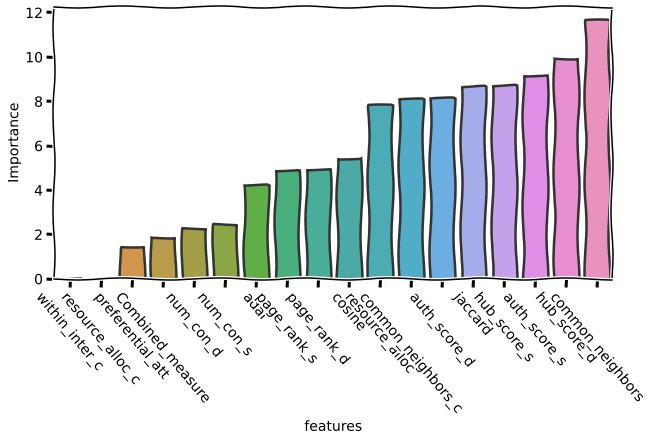

In [35]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x='features', y='Importance', 
                 data=pd.DataFrame(features_imp, columns=['features','Importance']), 
                 linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xticks(rotation=-50)
plt.show()

> Drop the features which have less importance

In [37]:
#drop irrelevant features based on features importance
drop_features =['within_inter_c',
                'resource_alloc_c', 
                'preferential_att']

X_train_new = X_train.drop(drop_features, axis=1)
X_test_new = X_test.drop(drop_features, axis=1)

In [38]:
print('Number of Features: ', X_train_new.shape[1])

Number of Features:  15


> Golden Features:
Golden Features for the CatBoost Classifier which highly contribute to predict the target variable or those variables which have high importance.

In [39]:
# index of golden_features for CatBoost Classifier
(list(X_train_new.columns).index('common_neighbors'),
list(X_train_new.columns).index('jaccard'))

(4, 0)

In [40]:
# golden_features for catboost classifier
golden_features = ['4:border_count=1024', '0:border_count=1024']

> Pass the golden features into the CatBoostClassifier

In [41]:
model = CatBoostClassifier(iterations=1000,
                           loss_function='Logloss',
                           eval_metric='Logloss',
                           random_state=2020,
                           verbose=100,
                           task_type="GPU",
                           od_type = "Iter", 
                           od_wait = 100,
                           learning_rate=0.01,
                           depth=5,
                           l2_leaf_reg=10,
                           per_float_feature_quantization=golden_features)

> Train the model after dropping the irrelevent features

In [42]:
model.fit(X_train_new, y_train)

0:	learn: 0.6627448	total: 17.7ms	remaining: 17.6s
100:	learn: 0.1278826	total: 1.7s	remaining: 15.1s
200:	learn: 0.1040905	total: 3.34s	remaining: 13.3s
300:	learn: 0.0967587	total: 5.5s	remaining: 12.8s
400:	learn: 0.0935196	total: 7.17s	remaining: 10.7s
500:	learn: 0.0907617	total: 9.07s	remaining: 9.04s
600:	learn: 0.0888684	total: 10.8s	remaining: 7.14s
700:	learn: 0.0872832	total: 12.4s	remaining: 5.3s
800:	learn: 0.0862552	total: 14.1s	remaining: 3.49s
900:	learn: 0.0854277	total: 16s	remaining: 1.76s
999:	learn: 0.0846805	total: 17.6s	remaining: 0us


## 4. Evaluate the Model
    Compute the performance of the link prediction model i.e CatBoost Classifier.

> Accuracy of Link Prediction model

In [43]:
model.score(X_test_n, y_test).round(2)

0.89

> ROC_AUC 

In [44]:
y_prob = model.predict_proba(X_test_n)
fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)

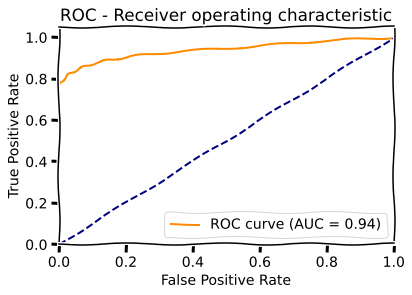

In [45]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

>    #### Conclusion:- Performance of proposed model for link     prediction is quite high in comparison to the baseline model.